In [1]:
import torch
import matplotlib.pyplot as plt
import ESN
import time
import numpy as np
import json

In [2]:
torch.set_default_device("cuda:0")
torch.set_default_dtype(torch.double)

In [3]:
""" TEMP  """
fn = "50N_tanh_10K"
## create target functions
with open('./experiments/settings/'+fn+'_s.txt', 'r') as fp:
    setting = json.load(fp)
u_sym = torch.load('./experiments/inputs/'+fn+'_i.pt')
Xwo = torch.load('./experiments/datamatrices/'+fn+'_d.pt')
Two = setting["Two"]
## set max delay, degree
maxdd=[[1,100],[2,10],[3,30],[4,10],[5,10],[6,5],[7,5]]

st = time.time()
target_info = ESN.make_targets(u_sym,maxdd,Two=Two)
print(r"target create time:%.3f s"%(time.time()-st))

torch.save(target_info,f"./experiments/target_info/{fn}_ti.pt")


basis table creation:0.003 s
1 degree:100 target functions
2 degree:55 target functions
3 degree:4960 target functions
4 degree:715 target functions
5 degree:2002 target functions
6 degree:210 target functions
7 degree:330 target functions
target create time:6.917 s


In [5]:
## calculate capacities
ti=target_info

st = time.time()
raw,lin,rev,sur = ESN.calc_capacity(Xwo,ti.tar_f,ret_all=True)
print(r"ipc calc time :%.3f s"%(time.time()-st))

cap = rev
ipc=ESN.IPC(cap,target_info.delay,target_info.degree,target_info.in_dim,target_info.maxddset)
torch.save(ipc,f"./experiments/ipcs/{fn}_ipc.pt")
torch.save(raw,f"./experiments/ipcs/{fn}_raw.pt")
torch.save(sur,f"./experiments/ipcs/{fn}_sur.pt")



ipc calc time :0.135 s


In [13]:
fn = input("set file name : ")

set file name :  50N_C0.6_tanh


In [15]:
# Parameters
Two,Ttrain = 2000,10000
N = 50
C = 0.6

dim = 1
sigma = 0.5
N_d = int(N * dim)
shftreg = False
idwin = False
actf = "identity"
actf = "tanh"

rseed=0

setting = {"input dim":dim,"Two":Two, "Ttrain":Ttrain,"sigma":sigma,rseed : rseed, 
            "Nodes":N,"uC":C, "actf":actf,"identical Win":idwin,"input dist":"uniform"}
# store experiment setting 
with open('./experiments/settings/'+fn+'_s.txt', 'x') as fp:
    data = json.dump(setting,fp)


In [16]:
## create input
torch.manual_seed(0)
u_asym = torch.rand(dim, Two + Ttrain)
#u_sym = u_asym
u_sym = 2 * u_asym - 1

torch.save(u_sym,f"./experiments/inputs/{fn}_i.pt")



In [17]:
## construct ESN model
## run and washout 
esn = ESN.ESN_mult(N_d, uC=C, dim=dim,idWin = idwin,sigma =sigma,rseed=rseed)
st = time.time()
Xwo = esn.run_washout(u_sym, Two, actf=actf)
print("runtime :",time.time()-st)

torch.save(Xwo,f"./experiments/datamatrices/{fn}_d.pt")



runtime : 0.7234556674957275


In [18]:
## calculate memory capacity

with open('./experiments/settings/'+fn+'_s.txt', 'r') as fp:
    setting = json.load(fp)
u = torch.load('./experiments/inputs/'+fn+'_i.pt')
Xwo = torch.load('./experiments/datamatrices/'+fn+'_d.pt')

N = setting["Nodes"]
dim = setting["input dim"]
if setting["identical Win"]:
    maxtau = int(N*1.5) 
else : maxtau =  int(N/dim *2) 

""" tweak maxtau here """
##
maxtau=int(N*4)
##


st = time.time()
#mfs = ESN.MC_cSVD_old(u_sym, Xwo, maxtau)
#mfs = ESN.MC_cSVD(u_sym, Xwo, maxtau)
mfs_raw, mfs_lin, mfs_rev, sur_value = ESN.MC_cSVD(u_sym, Xwo, maxtau,ret_all=True)
mfs = mfs_rev

print("mc calc time :",time.time()-st)
print("total MC :",float(torch.sum(mfs)))
torch.save(mfs,f"./experiments/mfs/{fn}_mf.pt")
torch.save(mfs_raw,f"./experiments/mfs/{fn}_raw.pt")
torch.save(sur_value,f"./experiments/mfs/{fn}_sur.pt")

print(float(sur_value))


mc calc time : 1.4574453830718994
total MC : 978.2541720677905
0.10002948495287922


In [144]:
print(float(torch.mean(raw_res[0][200:])))
print(float(torch.mean(mfs_lin[0][200:])))
print(float(torch.mean(mfs[0][200:])))

0.0009925384187713534
-2.3580366579990234e-05
-2.461494207345228e-05


In [18]:
## calculate ipc

## create target functions
with open('./experiments/settings/'+fn+'_s.txt', 'r') as fp:
    setting = json.load(fp)
u_sym = torch.load('./experiments/inputs/'+fn+'_i.pt')
Xwo = torch.load('./experiments/datamatrices/'+fn+'_d.pt')

Two = setting["Two"]

## set max delay, degree
maxdd=[[1,100],[2,10],[3,25],[4,10],[5,10]]


st = time.time()
target_info = ESN.make_targets(u_sym,maxdd,Two=Two)
print(r"target create time:%.3f s"%(time.time()-st))
torch.save(target_info,f"./experiments/target_info/{fn}_ti.pt")



basis table creation:0.003 s
1 degree:100 target functions
2 degree:55 target functions
3 degree:2925 target functions
4 degree:715 target functions
5 degree:2002 target functions
target create time:2.753 s


In [19]:
## calculate capacities
#
st = time.time()
ti = torch.load('./experiments/target_info/'+fn+'_ti.pt')
print(r"load time :%.3f s"%(time.time()-st))

st = time.time()
raw,lin,rev,sur = ESN.calc_capacity(Xwo,ti.tar_f,ret_all=True)
print(r"ipc calc time :%.3f s"%(time.time()-st))

capacities = rev
ipc=ESN.IPC(capacities,ti.delay,ti.degree,ti.in_dim,ti.maxddset)
torch.save(ipc,f"./experiments/ipcs/{fn}_ipc.pt")
torch.save(raw,f"./experiments/ipcs/{fn}_raw.pt")
torch.save(sur,f"./experiments/ipcs/{fn}_sur.pt")



load time :0.399 s
ipc calc time :0.014 s


In [21]:
#print(sur)
#print(torch.mean(raw))
#print(torch.mean(lin))
print("average ipc value:",float(torch.mean(rev)))

#mfs = torch.load(f"./experiments/mfs/{fn}_mf.pt")
c_d = torch.load(f"./experiments/ipcs/{fn}_ipc.pt")

#print(torch.mean(capacities))

capacities = c_d[0]
dgrs = c_d[1] 

totMC=float(torch.sum(mfs))
totCapacity = totMC+float(torch.sum(capacities))
print("totoal capacity:",totCapacity)
print("MC:",totMC)
c_2nd=torch.sum(capacities[torch.argwhere(dgrs==2)])
c_3rd=torch.sum(capacities[torch.argwhere(dgrs==3)])
c_4th=torch.sum(capacities[torch.argwhere(dgrs==4)])
c_5th=torch.sum(capacities[torch.argwhere(dgrs==5)])

print("2nd order ipc:",float(c_2nd))
print("3rd order ipc:",float(c_3rd))
print("4th order ipc:",float(c_4th))
print("5th order ipc:",float(c_5th))


average ipc value: 0.009647298225163015


FileNotFoundError: [Errno 2] No such file or directory: './experiments/ipcs/50N_C0.6_tanh_cd.pt'

In [128]:
sigmas = torch.linspace(0.1,2.0,39)

ipcs=torch.tensor(())
for sigma in sigmas:
    ipc=[]
    fn = f"100N_{sigma}s"
    mfs = torch.load(f"./experiments/mfs/{fn}_mf.pt")
    c_d = torch.load(f"./experiments/ipcs/{fn}_cd.pt")
    capacities = c_d[0]
    dgrs = c_d[1]
    
    
    totMC=float(torch.sum(mfs))
    totCapacity = totMC+float(torch.sum(capacities))
    print("totoal capacity:",totCapacity)
    #print("MC:",totMC)
    c_2nd=torch.sum(capacities[torch.argwhere(dgrs==2)])
    c_3rd=torch.sum(capacities[torch.argwhere(dgrs==3)])
    c_4th=torch.sum(capacities[torch.argwhere(dgrs==4)])
    c_5th=torch.sum(capacities[torch.argwhere(dgrs==5)])
    """
    print("2nd order ipc:",float(c_2nd))
    print("3rd order ipc:",float(c_3rd))
    print("4th order ipc:",float(c_4th))
    print("5th order ipc:",float(c_5th))
    """
    ipc = torch.tensor([totMC,c_2nd,c_3rd,c_4th,c_5th])
    ipcs = torch.cat((ipcs,ipc.unsqueeze(0)),0)


totoal capacity: 86.02329714510361
totoal capacity: 81.31197083812299
totoal capacity: 80.31906142795566
totoal capacity: 81.62038846000735
totoal capacity: 84.09173662451212
totoal capacity: 87.11037884079188
totoal capacity: 90.36450204034203
totoal capacity: 93.68253118699204
totoal capacity: 96.95742090593097
totoal capacity: 100.12126223766572
totoal capacity: 103.13649416432133
totoal capacity: 105.9885863255563
totoal capacity: 108.67558813955802
totoal capacity: 111.19899408044441
totoal capacity: 113.5593686422392
totoal capacity: 115.75517374211834
totoal capacity: 117.78239804939696
totoal capacity: 119.63434313645716
totoal capacity: 121.30196285922662
totoal capacity: 122.77501538879815
totoal capacity: 124.04381317337568
totoal capacity: 125.10108446129489
totoal capacity: 125.94346849244441
totoal capacity: 126.57234716612939
totoal capacity: 126.99394310494931
totoal capacity: 127.21879829264557
totoal capacity: 127.26084772606062
totoal capacity: 127.13631967198512
tot

tensor([0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000, 0.4500, 0.5000,
        0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000, 0.9500,
        1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000,
        1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500,
        1.9000, 1.9500, 2.0000], device='cuda:0')


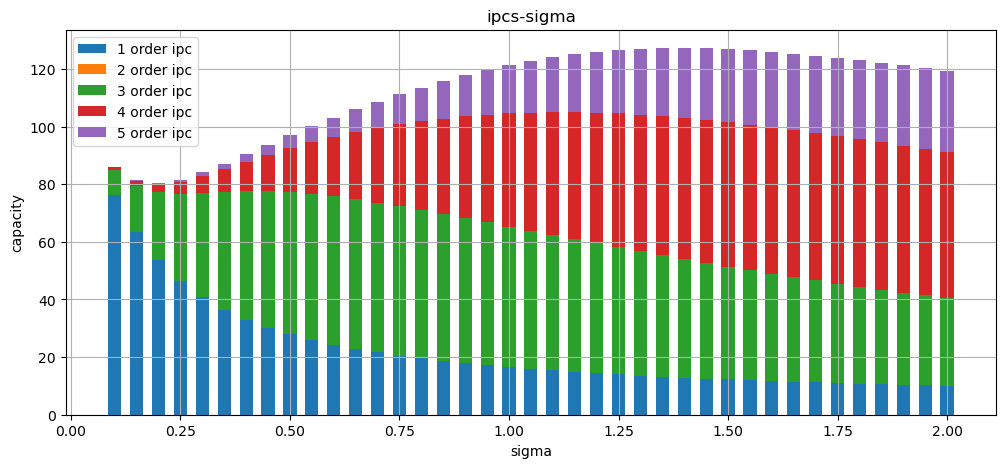

In [89]:
plt.figure(figsize=(12,5))
bottom=np.zeros(39)
print(sigmas)
for i in range(5):
    plt.bar(sigmas.cpu().numpy(),ipcs[:,i].cpu().numpy(),bottom=bottom,width=0.03,label=f"{i+1} order ipc")
    bottom+=ipcs[:,i].cpu().numpy()
plt.grid(True)
plt.title("ipcs-sigma")
plt.xlabel("sigma")
plt.ylabel("capacity")
plt.legend()

[ 9.99880851e+01 -1.98817358e-02  7.54862927e-02  6.42443252e-02
  1.34301339e-02]


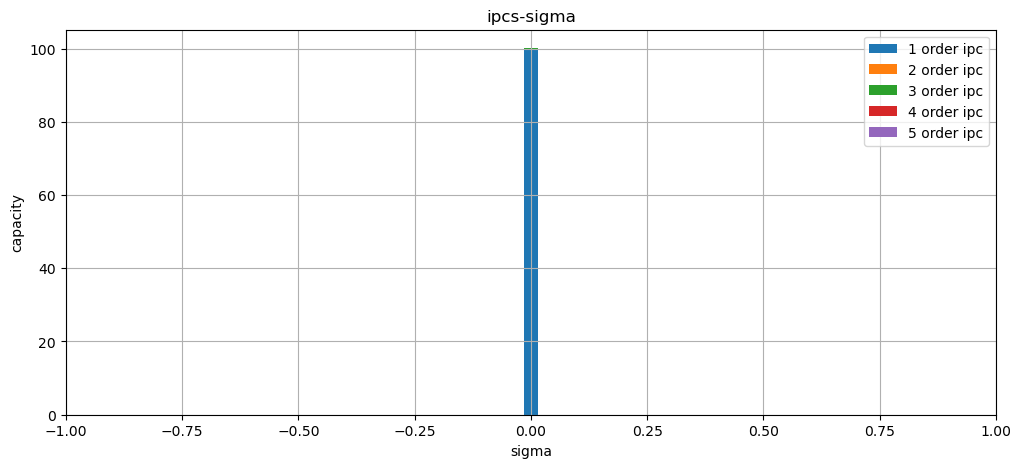

In [111]:
ipc = torch.tensor([totMC,c_2nd,c_3rd,c_4th,c_5th])
plt.figure(figsize=(12,5))
bottom=np.zeros(5)
for i in range(5):
    plt.bar(0,ipc[i].cpu().numpy(),bottom=bottom,width=0.03,label=f"{i+1} order ipc")
    bottom+=ipc[i].cpu().numpy()
plt.grid(True)
plt.xlim(-1,1)
plt.title("ipcs-sigma")
plt.xlabel("sigma")
plt.ylabel("capacity")
plt.legend()
print((ipc.cpu().numpy()))